In [ ]:
import numpy as np

Initialize all the weights, $U$, $W$, and $V$, by randomly drawing from the
uniform distribution:

# Forward propagation in RNN

In [ ]:
input_dim = 10
hidden_dim = 10
output_dim = 10

In [ ]:
U = np.random.uniform(-np.sqrt(1.0 / input_dim), np.sqrt(1.0 / input_dim), (hidden_dim, input_dim))
W = np.random.uniform(-np.sqrt(1.0 / hidden_dim), np.sqrt(1.0 / hidden_dim), (hidden_dim, hidden_dim))
V = np.random.uniform(-np.sqrt(1.0 / hidden_dim), np.sqrt(1.0 / hidden_dim), (input_dim, hidden_dim))

Define the number of time steps, which will be the length of our input
sequence, $x$:

In [ ]:
x = [10, 12, 14, 16, 18]

In [ ]:
num_time_steps = len(x)

In [ ]:
hidden_state = np.zeros((num_time_steps + 1, hidden_dim))

In [ ]:
hidden_state[-1] = np.zeros(hidden_dim)

In [ ]:
YHat = np.zeros((num_time_steps, output_dim))

In [ ]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=0)

In [ ]:
for t in np.arange(num_time_steps):
    # h_t = tanh(UX + Wh_{t-1})
    # hidden_state[t] = np.tanh(U[:, x[t]] + W.dot(hidden_state[t - 1]))
    # yhat_t = softmax(vh)
    YHat[t] = softmax(V.dot(hidden_state[t]))
YHat

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]])

# Generating song lyrics using RNNs


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import random
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [25]:
from google.colab import files
uploaded = files.upload()

Saving songdata.csv to songdata.csv


Read the downloaded input dataset:

In [26]:
df = pd.read_csv('songdata.csv')

Dataset exploration

In [27]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [28]:
df.shape[0]

57650

In [29]:
len(df['artist'].unique())

643

In [30]:
df['artist'].value_counts()[:10]

,count
artist,
Donna Summer,191
Gordon Lightfoot,189
Bob Dylan,188
George Strait,188
Loretta Lynn,187
Alabama,187
Cher,187
Reba Mcentire,187
Chaka Khan,186


In [31]:
df['artist'].value_counts().values.mean()

np.float64(89.65785381026438)

In [32]:
data = ', '.join(df['text'])

In [33]:
data[:369]

"Look at her face, it's a wonderful face  \nAnd it means something special to me  \nLook at the way that she smiles when she sees me  \nHow lucky can one fellow be?  \n  \nShe's just my kind of girl, she makes me feel fine  \nWho could ever believe that she could be mine?  \nShe's just my kind of girl, without her I'm blue  \nAnd if she ever leaves me what could I do, what co"

Since we are building a char-level RNN, we will store all the unique
characters in our dataset into a variable called chars; this is basically our vocabulary:


In [34]:
chars = sorted(list(set(data)))

In [35]:
vocab_size = len(chars)

In [36]:
char_to_ix = {ch: i for i, ch in enumerate(chars)}
ix_to_char = {i: ch for i, ch in enumerate(chars)}

In [37]:
print(char_to_ix['s'])

68


In [38]:
print(ix_to_char[68])

s


In [39]:
vocabSize = 7
char_index = 4
print(np.eye(vocabSize)[char_index])

[0. 0. 0. 0. 1. 0. 0.]


As we can see above, we now have a <strong>one hot encoded</strong>  value of each character.<br>We will encapsulate this one hot encoder into a function

In [41]:
def one_hot_encoder(index):
    return np.eye(vocab_size)[index]

## Defining the network parameters


In [42]:
hidden_size = 100

In [43]:
seq_length = 25

In [44]:
learning_rate = 1e-1

In [45]:
import tensorflow as tf
import random

In [46]:
seed_value = 42
tf.compat.v1.set_random_seed(seed_value)
random.seed(seed_value)

## Defining placeholders

In [47]:
tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [48]:
inputs = tf.compat.v1.placeholder(shape=[None, vocab_size],dtype=tf.float32, name="inputs")
targets = tf.compat.v1.placeholder(shape=[None, vocab_size], dtype=tf.float32, name="targets")

In [49]:
init_state = tf.compat.v1.placeholder(shape=[1, hidden_size], dtype=tf.float32, name="state")

In [50]:
initializer = tf.random_normal_initializer(stddev=0.1)

## Defining forward propagation

In [51]:
with tf.compat.v1.variable_scope("RNN") as scope:
    h_t = init_state
    y_hat = []

    for t, x_t in enumerate(tf.split(inputs, seq_length, axis=0)):
        if t > 0:
            scope.reuse_variables()

        #input to hidden layer weights
        U = tf.compat.v1.get_variable("U", [vocab_size, hidden_size], initializer=initializer)
        #hidden to hidden layer weights
        W = tf.compat.v1.get_variable("W", [hidden_size, hidden_size], initializer=initializer)
        #output to hidden layer weights
        V = tf.compat.v1.get_variable("V", [hidden_size, vocab_size], initializer=initializer)
        #bias for hidden layer
        bh = tf.compat.v1.get_variable("bh", [hidden_size], initializer=initializer)
        #bias for output layer
        by = tf.compat.v1.get_variable("by", [vocab_size], initializer=initializer)
        h_t = tf.tanh(tf.matmul(x_t, U) + tf.matmul(h_t, W) + bh)
        y_hat_t = tf.matmul(h_t, V) + by
        y_hat.append(y_hat_t)

Apply $softmax$ on the output and get the probabilities

In [52]:
output_softmax = tf.nn.softmax(y_hat[-1])
outputs = tf.concat(y_hat, axis=0)

In [53]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=targets, logits=outputs))

In [54]:
hprev = h_t

## Defining BPTT

In [55]:
minimizer = tf.compat.v1.train.AdamOptimizer()

In [56]:
gradients = minimizer.compute_gradients(loss)

In [57]:
threshold = tf.constant(5.0, name="grad_clipping")

In [58]:
clipped_gradients = []
for grad, var in gradients:
    clipped_grad = tf.clip_by_value(grad, -threshold, threshold)
    clipped_gradients.append((clipped_grad, var))

In [59]:
updated_gradients = minimizer.apply_gradients(clipped_gradients)

# Start generating songs

In [60]:
sess = tf.compat.v1.Session()
init = tf.compat.v1.global_variables_initializer()
sess.run(init)

In [61]:
pointer = 0
iteration = 0

In [62]:
while iteration < 50001:

    if pointer + seq_length+1 >= len(data) or iteration == 0:
        hprev_val = np.zeros([1, hidden_size])
        pointer = 0

    #select input sentence
    input_sentence = data[pointer:pointer + seq_length]

    #select output sentence
    output_sentence = data[pointer + 1:pointer + seq_length + 1]

    #get the indices of input and output sentence
    input_indices = [char_to_ix[ch] for ch in input_sentence]
    target_indices = [char_to_ix[ch] for ch in output_sentence]

    #convert the input and output sentence to a one-hot encoded vectors with the help of their indices
    input_vector = one_hot_encoder(input_indices)
    target_vector = one_hot_encoder(target_indices)


    #train the network and get the final hidden state
    hprev_val, loss_val, _ = sess.run([hprev, loss, updated_gradients],
                                      feed_dict={inputs: input_vector,targets: target_vector,init_state: hprev_val})


    #make predictions on every 500th iteration
    if iteration % 500 == 0:

        #length of characters we want to predict
        sample_length = 500

        #randomly select index
        random_index = random.randint(0, len(data) - seq_length)

        #sample the input sentence with the randomly selected index
        sample_input_sent = data[random_index:random_index + seq_length]

        #get the indices of the sampled input sentence
        sample_input_indices = [char_to_ix[ch] for ch in sample_input_sent]

        #store the final hidden state in sample_prev_state_val
        sample_prev_state_val = np.copy(hprev_val)

        #for storing the indices of predicted characters
        predicted_indices = []


        for t in range(sample_length):

            #convert the sampled input sentence into one-hot encoded vector using their indices
            sample_input_vector = one_hot_encoder(sample_input_indices)

            #compute the probability of all the words in the vocabulary to be the next character
            probs_dist, sample_prev_state_val = sess.run([output_softmax, hprev],
                                                      feed_dict={inputs: sample_input_vector,init_state: sample_prev_state_val})

            #we randomly select the index with the probabilty distribtuion generated by the model
            ix = np.random.choice(range(vocab_size), p=probs_dist.ravel())

            sample_input_indices = sample_input_indices[1:] + [ix]


            #store the predicted index in predicted_indices list
            predicted_indices.append(ix)

        #convert the predicted indices to their character
        predicted_chars = [ix_to_char[ix] for ix in predicted_indices]

        #combine the predcited characters
        text = ''.join(predicted_chars)

        #predict the predict text on every 50000th iteration
        if iteration % 5000 == 0:
            print ('\n')
            print (' After %d iterations' %(iteration))
            print('\n %s \n' % (text,))
            print('-'*115)


    #increment the pointer and iteration
    pointer += seq_length
    iteration += 1



 After 0 iterations

 eTTmn5nj4UC?3jb7zO[n:scB9-3?AKGprD9aRw
zswMa.?IB58qQxV1gq
G
3yB3ugx7h89RXz!w!1cAxeP9VG1[eo0cm!-PDtKdw1OrxEH:oKaXdbS0j8r[rGllnd40OePcl0t C[Scx2)DL?NG)W'oqIw5Uu:Y-1TPXFoSMwtpq7CtriWPvWS4eyY
PmcN,wRKHAEgTr5-ew)Sw0XEjnz:-21PSVA:A(OrT,0iGbJidze.A3qyIt4dyP-qZZCC999c1'9Ar,5BT4E9!R!A8NtVz6Z]tg24yV
j5rEegDB1.7]lw0,9DkR,im?GpZpvHriUrvr0]9(O
5-)1[M:gz1zQr,ZwB!F6Zv39gsndQ:G,IykQbgPx[bDGwgcRF)!rA(!B
yBpb"'i!tKwOJ-mP1zqRI4!i(Q.-so1p:SSERYU)6Oidu4:z(4QXtJitV40fWs-NtsvRmZV ocAgU7rvieb 1ZJ"iGHjI.oq,ieA:sb!'dC1,  

-------------------------------------------------------------------------------------------------------------------


 After 5000 iterations

 d bever bee arr o s it reverenmid  
Ha'me  
Ald waigft bucing ta sha s aly  
Bummet jfongeind ou to  
So Kfak hame get aloull tho sos tho cyouke wo  
 foun't sBver bean alorn be  
B at ave ooTent I cizesir seen jat dwastin bI fou met ow me, I'r siy tit't in do bole  
O dow me ancery in tould nime  
Ag7 uthengen  
Thos go line yo

# Different types of RNN architectures

1.   One-to-one architecture<br>
In a one-to-one architecture, a single input is mapped to a single output,
and the output from the time step t is fed as an input to the next time step.

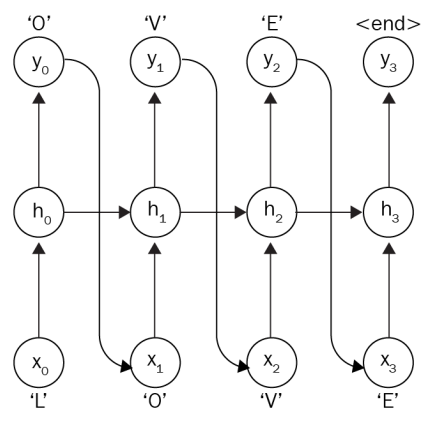

2.   One-to-many architecture<br>
In a one-to-many architecture, a single input is mapped to multiple hidden
states and multiple output values, which means RNN takes a single input and
maps it to an output sequence.

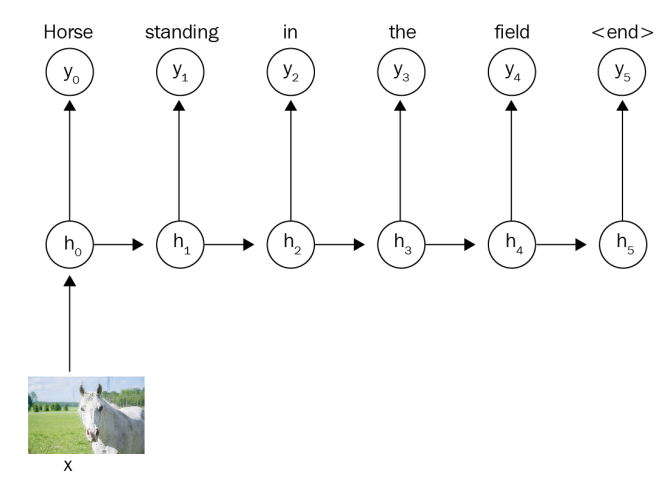

3. Many-to-one architectire:<br>
A many-to-one architecture, as the name suggests, takes a sequence of input
and maps it to a single output value.

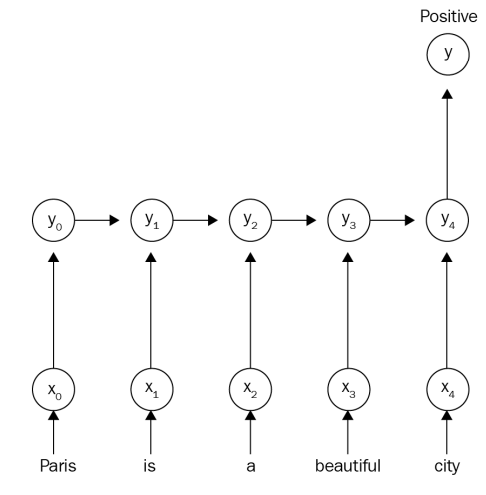

4. Many-to-many architecture:<br>
In many-to-many architectures, we map a sequence of input of arbitrary
length to a sequence of output of arbitrary length.

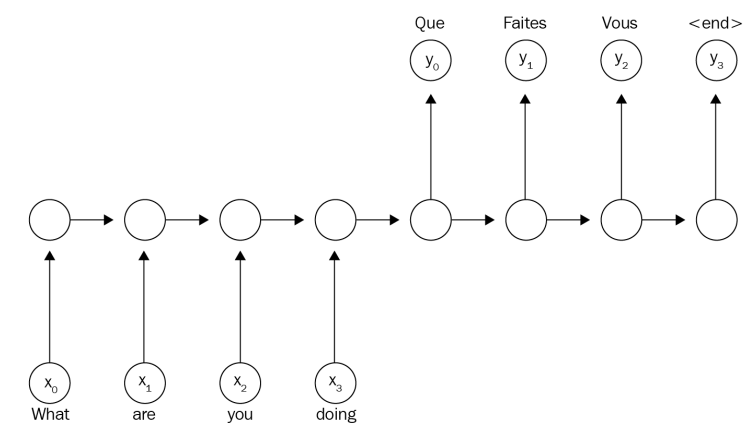